## TI3160TU: Natural Language Processing - Classification tasks Lab

Hey Stevan zie je dit!:

0. **Collecting dataset from Kaggle**
1. **Preprocessing the raw dataset**
2. **Extracting Bag of Words representations from the preprocessed dataset**
3. **Performing sentiment classification using Naive Bayes**
4. **Performance Considerations and Improvements**

## Step 1: Building a Naive Bayes classifier for sentiment analysis


### Preprocessing

#### Importing utilities

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
!pip install langdetect
from langdetect import detect

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=86118fc30d364530b9beb2b64a8af4d3a567662160fb9f5d554fa2aab75600db
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading data

In [3]:
raw_hotel_reviews = pd.read_csv('/content/drive/MyDrive/NLP_assignment/hotel-reviews 1.csv')

#### Preparing train dataset (encoding labels)

In [4]:
def dataset_prepare(dataset):
  dataset = dataset.copy()
  columns_to_drop = ['User_ID', 'Browser_Used', 'Device_Used']
  dataset = dataset.drop(columns=columns_to_drop, axis=1)
  dataset['Is_Response'].replace({'happy': 1, 'not happy': 0}, inplace=True)
  dataset = dataset.rename(columns={'Is_Response': 'label'})
  dataset = dataset.rename(columns={'Description': 'review'})

  return dataset

prepared_hotel_reviews = dataset_prepare(raw_hotel_reviews)

prepared_hotel_reviews.head()

,review,label
0,The room was kind of clean but had a VERY stro...,0
1,I stayed at the Crown Plaza April -- - April -...,0
2,I booked this hotel through Hotwire at the low...,0
3,Stayed here with husband and sons on the way t...,1
4,My girlfriends and I stayed here to celebrate ...,0


In [5]:
# lets check how many samples we have
print("Number of samples: All=%d Positive=%d Negative=%d" %(prepared_hotel_reviews.shape[0], prepared_hotel_reviews[prepared_hotel_reviews.label==1].shape[0], prepared_hotel_reviews[prepared_hotel_reviews.label==0].shape[0]))

Number of samples: All=38932 Positive=26521 Negative=12411


#### Preprocessing train dataset

For the purposes of this simple classification task, we will preprocess the raw dataset using the following steps:
- Normalize text by converting everything to lowercase
- Remove punctuation, numbers, special characters, etc.
- Stem all the words

In [6]:
# Helper function to preprocess text
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation, numbers, special characters, etc.
    text = re.sub('[^a-z]', ' ', text)

    # Remove stopwords and stem
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)

    return text

In [7]:
stemmer = PorterStemmer()
def preprocess_data(df):
  df['preprocessed_review'] = df['review'].apply(preprocess_text)

  preprocessed_df = df.drop('review', axis=1)

  preprocessed_df = preprocessed_df[['preprocessed_review', 'label']] # Rearrange columns in the DataFrame

  preprocessed_df = preprocessed_df.rename(columns={'preprocessed_review': 'review'})
  return preprocessed_df

preprocessed_hotel_reviews = preprocess_data(prepared_hotel_reviews)


In [8]:
print(preprocessed_hotel_reviews)

                                                  review  label
0      room kind clean strong smell dog gener averag ...      0
1      stay crown plaza april april staff friendli at...      0
2      book hotel hotwir lowest price could find got ...      0
3      stay husband son way alaska cruis love hotel g...      1
4      girlfriend stay celebr th birthday plan weeken...      0
...                                                  ...    ...
38927  arriv late night walk check area complet flood...      1
38928  posit impress locat public park opposit site s...      0
38929  travel friend shop show locat great best say r...      0
38930  experi ok paid extra view pool got view palm t...      0
38931  westin wonder restor grand dame hotel bed line...      1

[38932 rows x 2 columns]


### Training and validation

In [9]:
X = preprocessed_hotel_reviews['review'].values
y = preprocessed_hotel_reviews['label'].values

#### Splitting the data for training, validation and testing

In [10]:
comments_trainval, comments_test, y_trainval, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#### Tuning number of BoW features

In [11]:
num_samples = [12500, 15000, 20000, 25000, 30338]
def validation():

  accuracies = []

  for num in num_samples:

      # instatiate our BoW vectorizer
      vectorizer_num_samples = CountVectorizer(max_features=num)

      # here, we extract our BoW array. This will be the input to our classifier
      X_trainval = vectorizer_num_samples.fit_transform(comments_trainval)

      # split the dataset
      # defining random_state is important here as we aim to re-run this multiple times so we want to keep the same split
      X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1/9, random_state=42)

      # we train our Naive Bayes classifier. Note that here we only use the training set.
      my_classifier = MultinomialNB()
      my_classifier.fit(X_train, y_train)

      # first we use the classifier to make predictions with all the samples that are included in the test set
      my_y_pred = my_classifier.predict(X_val)

      #then, we compare the predicted labels with the ground truth labels to calculate the accuracy, precision, recall, and f1_score of our classifer
      accuracies.append(accuracy_score(y_val, my_y_pred))
  return accuracies

accuracies = validation()
accuracies


[0.8649203903441192,
 0.8649203903441192,
 0.864406779661017,
 0.8659476117103235,
 0.866974833076528]

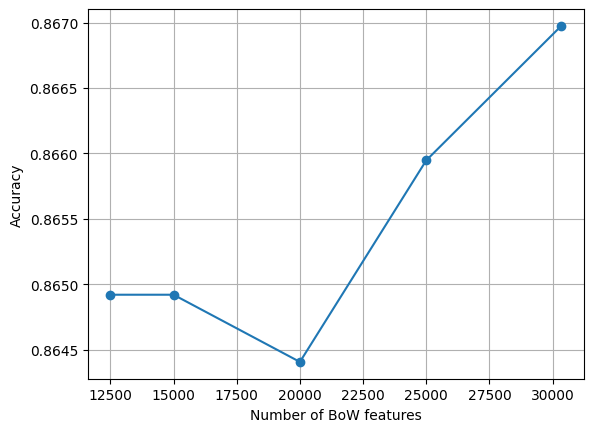

In [12]:
# Create the line plot
plt.plot(num_samples, accuracies, marker='o', linestyle='-')

# Customize the plot
plt.xlabel("Number of BoW features")
plt.ylabel("Accuracy")
plt.grid(True)

# Display the plot
plt.show()

#### Training final classifier



In [13]:
def final_classifier():
  vectorizer = CountVectorizer()
  X_trainval = vectorizer.fit_transform(comments_trainval)
  X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=1/9, random_state=42)
  my_classifier = MultinomialNB()
  my_classifier.fit(X_train, y_train)
  return my_classifier, vectorizer

final_classifier, vectorizer = final_classifier()

### Generalization accuracy

#### Test set

In [16]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(comments_test)
y_pred = final_classifier.predict(X_test)
print("Accuracy: %.3f" %(accuracy_score(y_test, y_pred)))
print("Precision: %.3f" %(precision_score(y_test, y_pred)))
print("Recall: %.3f" %(recall_score(y_test, y_pred)))
print("F1-Score: %.3f" %(f1_score(y_test, y_pred)))
conf_matrix = confusion_matrix(y_test, y_pred)

Accuracy: 0.862
Precision: 0.884
Recall: 0.917
F1-Score: 0.901


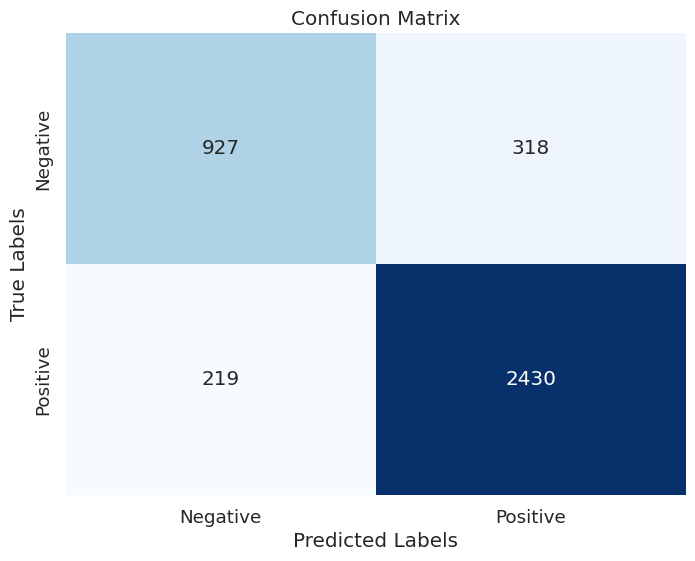

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

labels = ['Negative', 'Positive']

plot_confusion_matrix(conf_matrix, labels)

### Accuracy on unseen Airbnb data

In [ ]:
def preprocess_airbnb(df):
  new_df = df.copy()
  new_df['preprocessed_comment'] = new_df['comments'].apply(preprocess_text)
  new_df = new_df[['preprocessed_comment']]

  X = vectorizer.transform(new_df['preprocessed_comment'].values)

  return X

In [ ]:
file_path_airbnb_labels = '/content/drive/MyDrive/NLP_assignment/labelled_airbnb_data.xlsx'
airbnb_labels_df = pd.read_excel(file_path_airbnb_labels)
comments_df = airbnb_labels_df[['comments']]
labels = airbnb_labels_df[['labels']].values
preprocessed_labeled_data = preprocess_airbnb(comments_df)
predictions_labeled_data = final_classifier.predict(preprocessed_labeled_data)
print("Accuracy: %.3f" %(accuracy_score(labels, predictions_labeled_data)))
confusion_matrix(labels, predictions_labeled_data)

Accuracy: 0.975


array([[242,   8],
       [ 11, 489]])

## Step 2: Applying built classifier on Airbnb data

## Preprocessing dataset

### Loading Airbnb data

In [ ]:
file_path_NYC = '/content/drive/MyDrive/NLP_assignment/NYC_excel_prepared_16k_tiny.xlsx'
file_path_Austin = '/content/drive/MyDrive/NLP_assignment/Austin_excel_prepared_17k_tiny.xlsx'
file_path_Melbourne = '/content/drive/MyDrive/NLP_assignment/Melbourne_excel_prepared_30k_small.xlsx'
file_path_Capetown = '/content/drive/MyDrive/NLP_assignment/Capetown_excel_prepared_23k_tiny.xlsx'

raw_NYC_comments = pd.read_excel(file_path_NYC)
raw_Austin_comments = pd.read_excel(file_path_Austin)
raw_Melbourne_comments = pd.read_excel(file_path_Melbourne)
raw_Capetown_comments = pd.read_excel(file_path_Capetown)

print(raw_NYC_comments)

                                                comments
0      Waldemar was very nice but could have communic...
1      Waldemar is a very kind and mild mannered host...
2      Jennifer's place is lovely. As a host, she was...
3      The home was convenient  and spacious, as adve...
4      Travelers will find a very friendly and helpfu...
...                                                  ...
16468  It was my first experience with airbnb and a v...
16469  Petite chambre trÃ¨s propre avec sa SDB et ses...
16470  Lovely home and an unbeatable location. Beauti...
16471  Such a great spot! The room is small-ish but h...
16472  I had a wonderful time @ carol's place! Room i...

[16473 rows x 1 columns]


###Language Detector

In [ ]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        # Handle cases where language detection fails
        return False

# Assuming 'comments' is the column containing the reviews in your DataFrame
# Adjust the code according to your DataFrame structure

def english_preprocess(df):
  df['is_english'] = df['comments'].apply(is_english)

  # Filter out non-English comments
  english_comments_df = df[df['is_english']]

  # Drop the temporary 'is_english' column if needed
  english_comments_df = english_comments_df.drop(columns=['is_english'])

  # Display the DataFrame with only English comments
  df_reset = english_comments_df.reset_index()
  df_reset = df_reset[['comments']]
  return df_reset

# english_NYC_comments_df = english_preprocess(raw_NYC_comments)
english_Austin_comments_df = english_preprocess(raw_Austin_comments)
# english_Melbourne_comments_df = english_preprocess(raw_Melbourne_comments)
# english_Capetown_comments_df = english_preprocess(raw_Capetown_comments)


In [ ]:
print(english_Austin_comments_df.shape)
english_Austin_comments_df.nunique()

(17611, 1)


comments    17477
dtype: int64

### Preprocessing data

In [ ]:
def preprocess_airbnb(df):
  new_df = df.copy()
  new_df['preprocessed_comment'] = new_df['comments'].apply(preprocess_text)
  new_df = new_df[['preprocessed_comment']]

  X = vectorizer.transform(new_df['preprocessed_comment'].values)

  return X

X_NYC = preprocess_airbnb(english_NYC_comments_df)
X_Austin = preprocess_airbnb(english_Austin_comments_df)
X_Melbourne = preprocess_airbnb(english_Melbourne_comments_df)
X_Capetown = preprocess_airbnb(english_Capetown_comments_df)

In [ ]:
predictions_NYC = final_classifier.predict(X_NYC)
predictions_Austin = final_classifier.predict(X_Austin)
predictions_Melbourne = final_classifier.predict(X_Melbourne)
predictions_Capetown = final_classifier.predict(X_Capetown)

print('NYC: ', np.mean(predictions_NYC))
print('Austin', np.mean(predictions_Austin))
print('Melbourne: ', np.mean(predictions_Melbourne))
print('Capetown', np.mean(predictions_Capetown))

NYC:  0.9342167534311405
Austin 0.9227755380160128
Melbourne:  0.9755675526024363
Capetown 0.8941500073677489


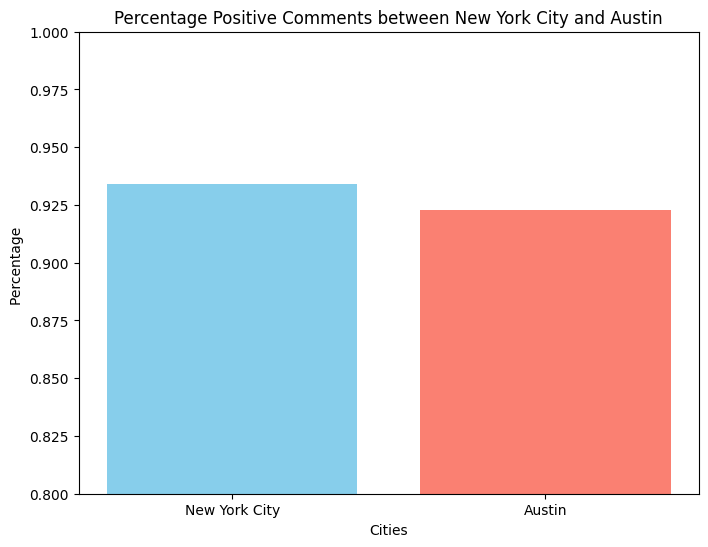

In [ ]:
import matplotlib.pyplot as plt

# Your two values for New York City and Austin
values = [np.mean(predictions_NYC), np.mean(predictions_Austin)]  # Replace these values with your own

# Names for the bars
cities = ['New York City', 'Austin']

plt.figure(figsize=(8, 6))

# Creating the bar chart
plt.bar(cities, values, color=['skyblue', 'salmon'])
plt.ylim(0.80, 1.0)
# Adding labels and title
plt.xlabel('Cities')
plt.ylabel('Percentage ')
plt.title('Percentage Positive Comments between New York City and Austin')

# Show the plot
plt.show()

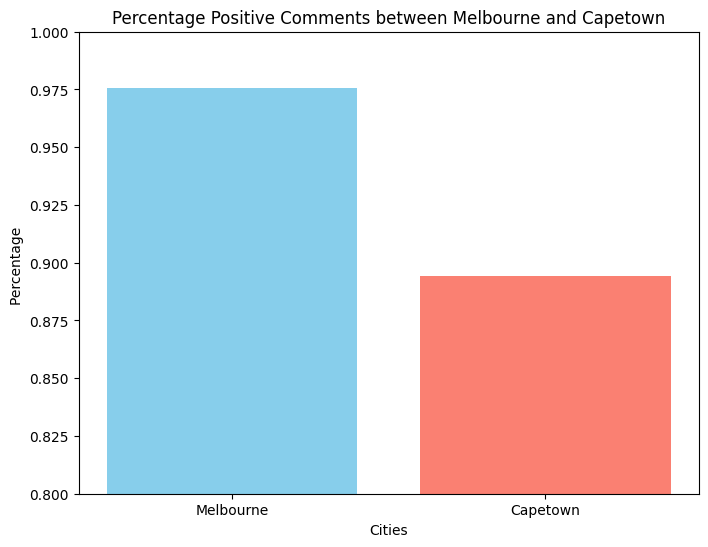

In [ ]:

values = [np.mean(predictions_Melbourne), np.mean(predictions_Capetown)]  # Replace these values with your own

# Names for the bars
cities = ['Melbourne', 'Cape Town']

plt.figure(figsize=(8, 6))

# Creating the bar chart
plt.bar(cities, values, color=['skyblue', 'salmon'])
plt.ylim(0.80, 1.0)
# Adding labels and title
plt.xlabel('Cities')
plt.ylabel('Percentage ')
plt.title('Percentage Positive Comments between Melbourne and Cape Town')

# Show the plot
plt.show()